## Description

Here we implement Transfer Learning by using pretrained resnet18 model from Huggingface.

## Notes

#### should test performed with best results of each fold or trained model or both?


In [ ]:
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoModelForImageClassification, ResNetForImageClassification
from torchvision import transforms
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from src.evaluate import validation_of_pretrained_model

cmap = plt.get_cmap('Greys_r')

import os
from concurrent.futures import ThreadPoolExecutor

from utils import (
    plot_subplots,
    plot_class_distribution,
    FocalLoss
)

from src.dataset import CloudHoleDataset
from src.train import train_model, validate_model
from src.utils import early_stopping, plot_training_curves

/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-26 18:03:29.010017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769447009.137248   14194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769447009.176721   14194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-26 18:03:29.395065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical

In [ ]:

# berke TODO: which dates are not augmentated? why? 51 missing meaning 17 datetime did not augmentated

TRAIN_YEARS = [2005, 2007, 2010, 2013, 2016]
TEST_YEARS = [2015, 2017] # TODO: find other test years
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CloudHoleDataset(
    labels = "./labels.csv",
    nc_dir = "../sat_data", 
    train = True, 
    years = TRAIN_YEARS
    # years = pd.DatetimeIndex(labels.index).year.unique().to_list()
)

print(dataset.mean, dataset.std, dataset.min, dataset.max)

test_dataset = CloudHoleDataset('./labels.csv', '../sat_data', False, years = TEST_YEARS, mean = dataset.mean, std = dataset.std, min = dataset.min, max = dataset.max)

tensor(12.9604) tensor(7.3490) 41.49020004272461 -0.10120142996311188


### Visualization of Original and Augmented Images

Visualizing for controlling how augmentation works or to inspect suspicious data from prediction results.

Number of images (original + augmentations) for 2007-02-19 11:00:00: 4
Augmentation 1: Image Shape: torch.Size([3, 224, 224])
Augmentation 2: Image Shape: torch.Size([3, 224, 224])
Augmentation 3: Image Shape: torch.Size([3, 224, 224])
Augmentation 4: Image Shape: torch.Size([3, 224, 224])


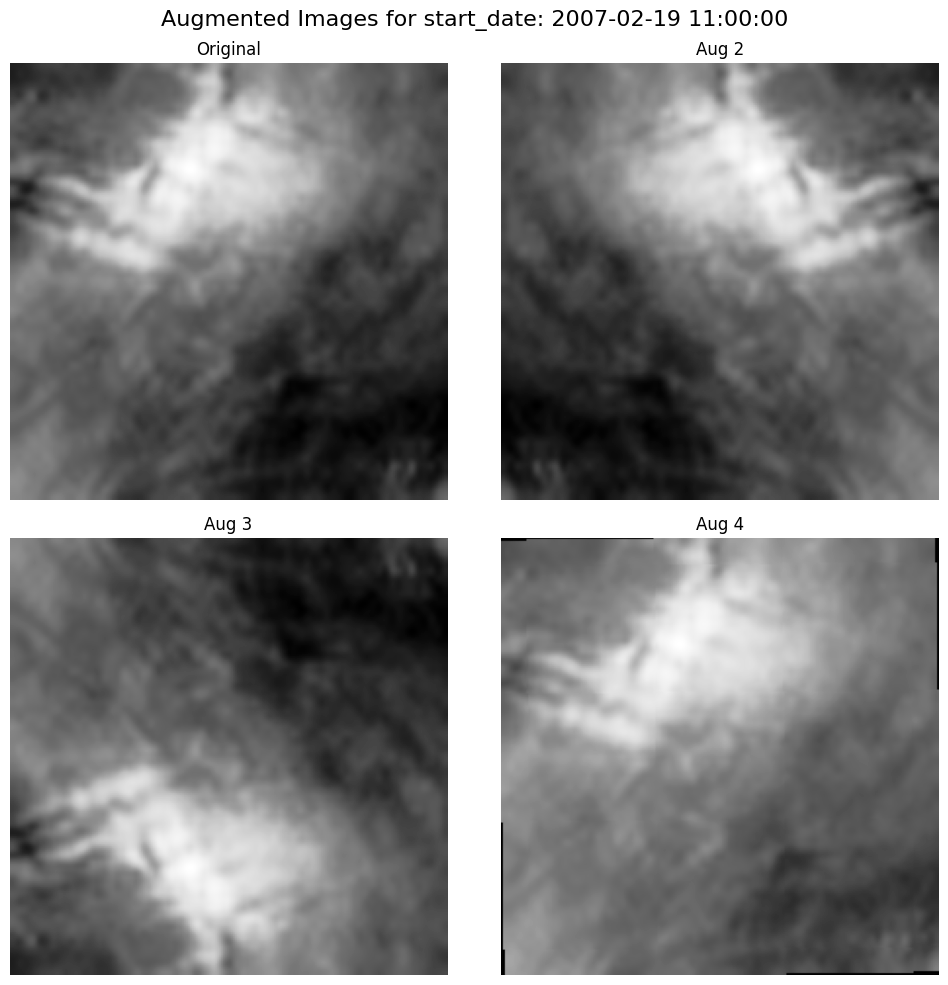

In [4]:
desired_date = "2007-02-19 11:00:00"

# Filter augmented and original images for the desired date
filtered_resized_data = [
    (start_date, image_data)
    for start_date, image_data in dataset.ds_list_resized_normalized
    if str(start_date) == desired_date
]

print(f"Number of images (original + augmentations) for {desired_date}: {len(filtered_resized_data)}")

# Example: Access augmented image shapes
for idx, (start_date, image_data) in enumerate(filtered_resized_data):
    print(f"Augmentation {idx + 1}: Image Shape: {image_data.shape}")
    
plot_subplots(filtered_resized_data, title=f"Augmented Images for start_date: {desired_date}", figsize=(10, 10), idx_channel=1)

### plot class distribution

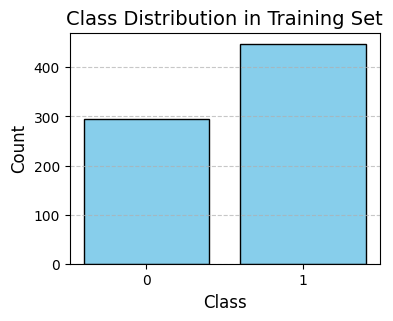

dataset Distribution: Counter({1: 448, 0: 294})


In [5]:
from collections import Counter

_train_dataloader_one_batch = DataLoader(dataset, batch_size=1, shuffle=False)

all_train_labels = []

for _, label_tensor in _train_dataloader_one_batch:
    all_train_labels.append(label_tensor.item())

plot_class_distribution(all_train_labels, dataset_name="Training Set")

print("dataset Distribution:", Counter(all_train_labels))


### configuration of hyperparameters


In [6]:
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-5
NUM_SPLITS_TSCV = 5
EARLY_STOPPING_PATIENCE = 10


### Training via Transfer Learning by using pretrained resnet 18

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1/5
	TRAIN indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
	VALIDATION indices: [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234

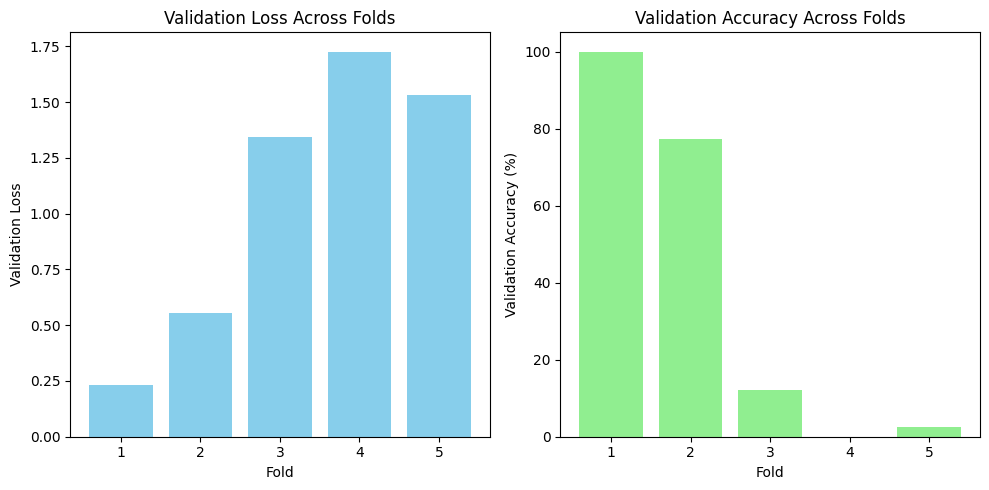

Average Validation Loss: 1.0776
Average Validation Accuracy: 38.37%


In [ ]:


# TODO berke: move all functions to classes for transferlearning, plots and so forth.

model_pretrained = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-18",
    num_labels = 2,
    ignore_mismatched_sizes=True
)

# Freeze all layers except the classifier
for param in model_pretrained.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

model_pretrained.to(DEVICE)



def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, fold):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(val_accuracies, 'b-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Fold {fold + 1} - Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, 'r-', label='Training Loss')
    plt.plot(val_losses, 'b-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} - Training vs Validation Loss')
    plt.legend()
    plt.grid(True) 
    
    plt.tight_layout()
    plt.savefig(f'training_curves_fold_{fold + 1}.png')
    plt.close()

from torch.optim.lr_scheduler import ReduceLROnPlateau

# criterion = FocalLoss(alpha=0.01, gamma=10, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Initialize ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


train_losses, val_losses, train_accuracies, val_accuracies, fold_metrics, model_pretrained = validation_of_pretrained_model(
    batch_size=BATCH_SIZE,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    num_splits=NUM_SPLITS_TSCV,
    patience=EARLY_STOPPING_PATIENCE,
    model = model_pretrained
)
    


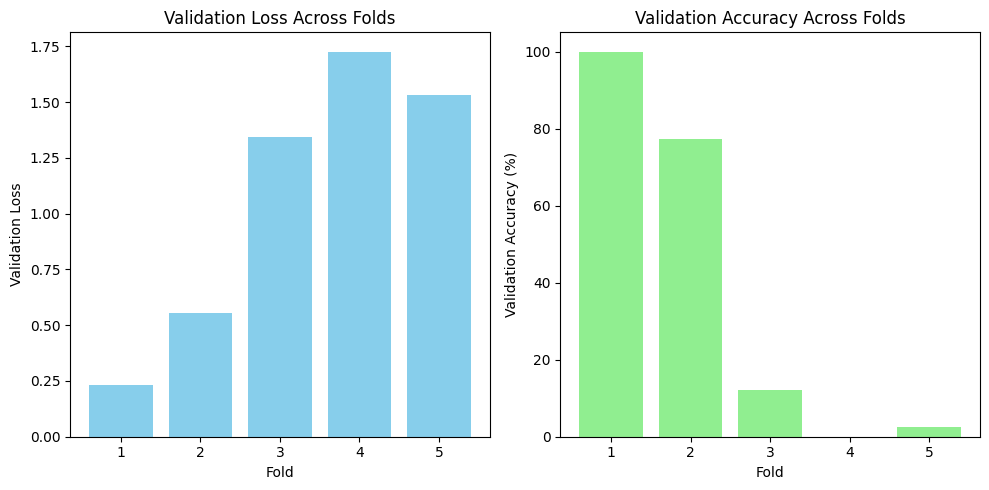

In [8]:
folds = range(1, NUM_SPLITS_TSCV + 1)
val_loss_per_fold = [metrics[0] for metrics in fold_metrics]
val_acc_per_fold = [metrics[1] for metrics in fold_metrics]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(folds, val_loss_per_fold, color='skyblue')
plt.xlabel("Fold")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Folds")

plt.subplot(1, 2, 2)
plt.bar(folds, val_acc_per_fold, color='lightgreen')
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Folds")

plt.tight_layout()
plt.show()


## Testing with Best results of each Folds: they're saved as best_model_fold_*.pth

Evaluating Test Set with Best Model of Fold 1


/tmp/ipykernel_14194/396299326.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"best_model_fold_{fold + 1}.pth")


Fold 1 - Test Loss: 0.0001, Test Accuracy: 87.91%
Evaluating Test Set with Best Model of Fold 2
Fold 2 - Test Loss: 0.0001, Test Accuracy: 89.01%
Evaluating Test Set with Best Model of Fold 3
Fold 3 - Test Loss: 0.0001, Test Accuracy: 88.46%
Evaluating Test Set with Best Model of Fold 4
Fold 4 - Test Loss: 0.0001, Test Accuracy: 89.01%
Evaluating Test Set with Best Model of Fold 5
Fold 5 - Test Loss: 0.0001, Test Accuracy: 89.56%

Overall Test Loss (Average across folds): 0.0001
Overall Test Accuracy (Average across folds): 88.79%

Overall Classification Report:
                precision    recall  f1-score   support

Non Cloud Hole       0.89      1.00      0.94       800
    Cloud Hole       1.00      0.07      0.14       110

      accuracy                           0.89       910
     macro avg       0.94      0.54      0.54       910
  weighted avg       0.90      0.89      0.84       910



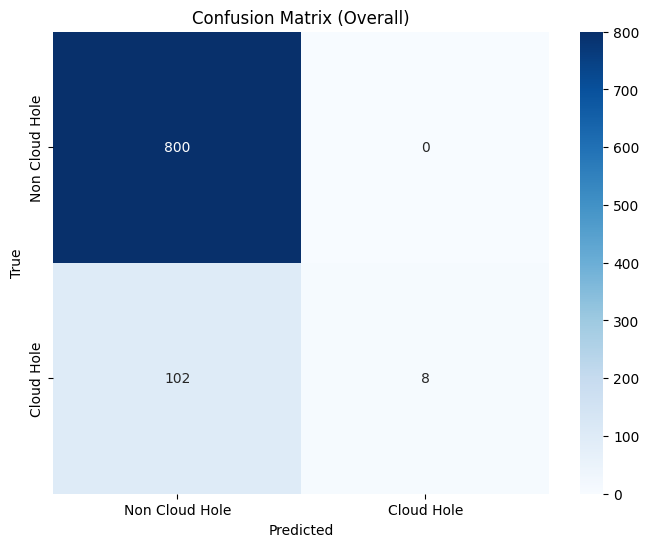

Final model trained and saved as final_model.pth


In [9]:
def evaluate_model(model, test_loader, criterion, device):
    """Evaluate the model on the test set."""
    test_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total

    return test_loss, test_accuracy, all_labels, all_predictions

def evaluate_folds(model, test_dataset, criterion, device, num_splits_tscv, batch_size):
    """Evaluate the model across all folds and return metrics."""
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    fold_test_metrics = []  # To store metrics for each fold
    all_test_labels = []
    all_test_predictions = []

    # Loop through all folds
    for fold in range(num_splits_tscv):
        print(f"Evaluating Test Set with Best Model of Fold {fold + 1}")
        
        checkpoint = torch.load(f"best_model_fold_{fold + 1}.pth")
        model.load_state_dict(checkpoint['model_state_dict'])   
        model.eval()
        model.to(device)

        # Evaluate the model
        test_loss, test_accuracy, fold_labels, fold_predictions = evaluate_model(model, test_loader, criterion, device)
        
        print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        
        # Save metrics for this fold
        fold_test_metrics.append((test_loss, test_accuracy))
        all_test_labels.extend(fold_labels)
        all_test_predictions.extend(fold_predictions)

    return fold_test_metrics, all_test_labels, all_test_predictions

def compute_overall_metrics(fold_test_metrics):
    """Compute overall metrics across all folds."""
    avg_test_loss = np.mean([metrics[0] for metrics in fold_test_metrics])
    avg_test_accuracy = np.mean([metrics[1] for metrics in fold_test_metrics])
    return avg_test_loss, avg_test_accuracy

def plot_confusion_matrix(all_test_labels, all_test_predictions, class_names):
    """Plot confusion matrix."""
    conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Overall)")
    plt.show()

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

CLASS_NAMES = ["Non Cloud Hole", "Cloud Hole"]  # Class names for classification report and confusion matrix
criterion = FocalLoss(alpha=0.01, gamma=10, num_classes=2)

fold_test_metrics = []  # To store metrics for each fold
all_test_labels = []
all_test_predictions = []

fold_test_metrics, all_test_labels, all_test_predictions = evaluate_folds(
    model_pretrained, test_dataset, criterion, DEVICE, NUM_SPLITS_TSCV, BATCH_SIZE
)

avg_test_loss, avg_test_accuracy = compute_overall_metrics(fold_test_metrics)

print(f"\nOverall Test Loss (Average across folds): {avg_test_loss:.4f}")
print(f"Overall Test Accuracy (Average across folds): {avg_test_accuracy:.2f}%")

print("\nOverall Classification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=CLASS_NAMES))

plot_confusion_matrix(all_test_labels, all_test_predictions, CLASS_NAMES)


torch.save(model_pretrained.state_dict(), "final_model.pth")
print("Final model trained and saved as final_model.pth")

## Testing with only Final Model (model saved as final_model.pth)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_14194/3612565144.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. 


Final Model Test Loss: 0.0001
Final Model Test Accuracy: 89.56%

Final Model Classification Report:
                precision    recall  f1-score   support

Non Cloud Hole       0.89      1.00      0.94       160
    Cloud Hole       1.00      0.14      0.24        22

      accuracy                           0.90       182
     macro avg       0.95      0.57      0.59       182
  weighted avg       0.91      0.90      0.86       182



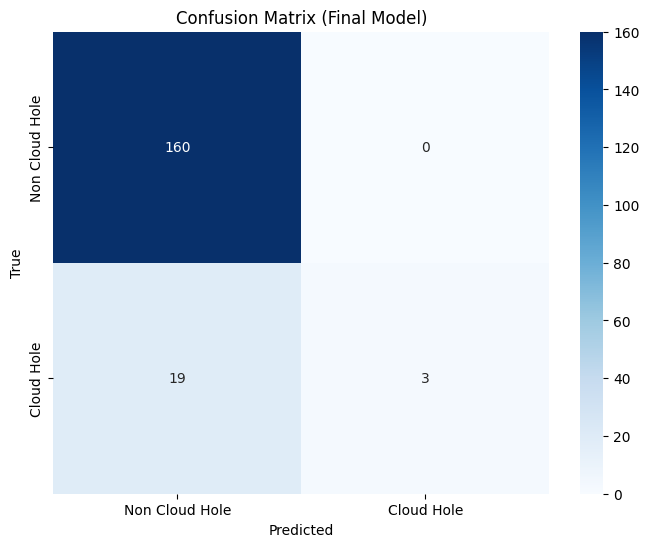

In [10]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# model = configure_pretrained_model()

model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-18",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load("final_model.pth"))
model.to(DEVICE)
model.eval()

final_test_loss, final_test_accuracy, final_test_all_labels, final_test_all_predictions = evaluate_model(model, test_loader, criterion, DEVICE)

print(f"\nFinal Model Test Loss: {final_test_loss:.4f}")
print(f"Final Model Test Accuracy: {final_test_accuracy:.2f}%")

print("\nFinal Model Classification Report:")
print(classification_report(final_test_all_labels, final_test_all_predictions, target_names=["Non Cloud Hole", "Cloud Hole"]))

conf_matrix = confusion_matrix(final_test_all_labels, final_test_all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Cloud Hole", "Cloud Hole"], yticklabels=["Non Cloud Hole", "Cloud Hole"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Final Model)")
plt.show()

In [11]:
import numpy as np

all_labels = np.array(final_test_all_labels)  # True labels
all_predictions = np.array(final_test_all_predictions)  # Model predictions

# Identify misclassified indices
false_negatives = np.where((all_labels == 1) & (all_predictions == 0))[0]

print("Indices of misclassified Cloud Hole as Non Cloud Hole:", false_negatives)


Indices of misclassified Cloud Hole as Non Cloud Hole: [  2   3   4   5   6  10  11  12  13  14  15 123 124 126 127 130 131 133
 156]


In [12]:
for idx in false_negatives[:5]:
    print(f"Index: {idx} Date: {test_dataset.dates.index[idx]}")
    print(f"min: {test_dataset[idx][0].min().item()}, max: {test_dataset[idx][0].max().item()}")

    

Index: 2 Date: 2015-01-17 08:30:00
min: 0.4446747303009033, max: 0.9410691857337952
Index: 3 Date: 2015-01-17 08:45:00
min: 0.4446747303009033, max: 0.930579423904419
Index: 4 Date: 2015-01-17 09:00:00
min: 0.36758896708488464, max: 0.9218162894248962
Index: 5 Date: 2015-01-17 09:15:00
min: 0.36758896708488464, max: 0.9132457375526428
Index: 6 Date: 2015-01-17 09:30:00
min: 0.3652857840061188, max: 0.896832287311554


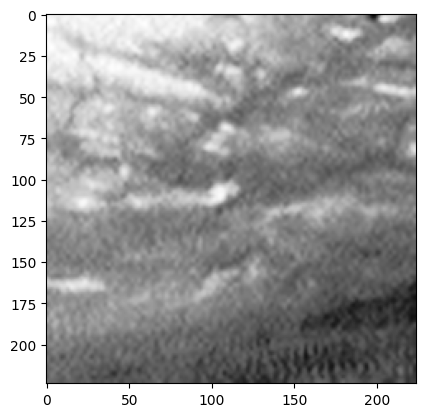

In [13]:
for (date, data) in dataset.ds_list_resized_normalized[:1]:  # Show the first 5 misclassified samples
      # Fetch the image
    plt.imshow(data[0], cmap=cmap)  # Convert PyTorch tensor to image format
    plt.show()

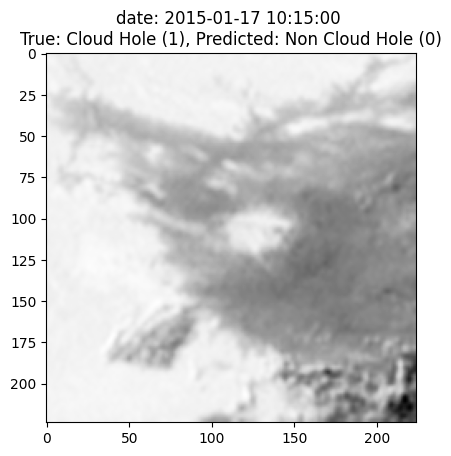

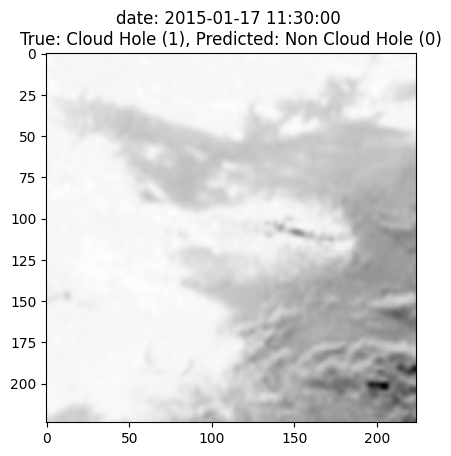

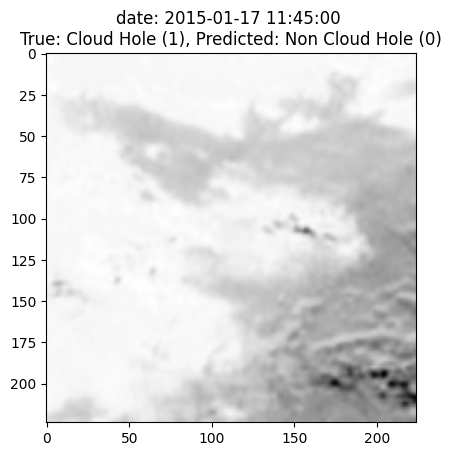

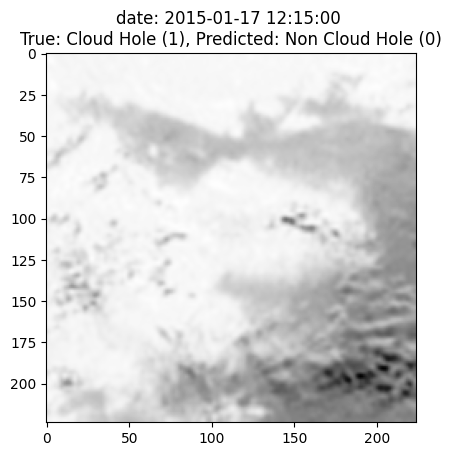

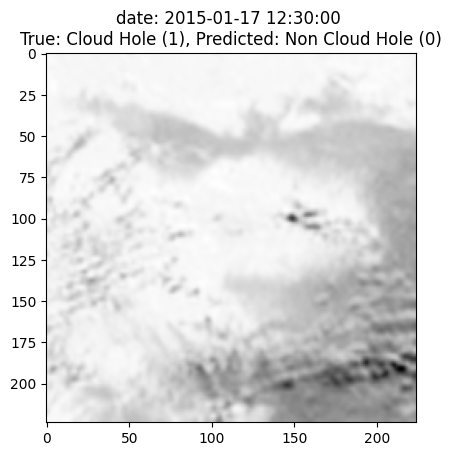

In [16]:

cmap = plt.get_cmap('Greys_r')

for idx in false_negatives[:5]:  # Show the first 5 misclassified samples
    date, data = test_dataset.ds_list_resized_normalized[idx]  # Fetch the image
    plt.imshow(data[0], cmap=cmap)  # Convert PyTorch tensor to image format
    plt.title(f"date: {date} \nTrue: Cloud Hole (1), Predicted: Non Cloud Hole (0)")
    plt.show()



In [21]:
misclassified_df = pd.DataFrame({
    "Index": false_negatives,
    "True Label": all_labels[false_negatives],
    "Predicted Label": all_predictions[false_negatives]
})

misclassified_df.to_csv("misclassified_cloud_holes.csv", index=False)

print("Saved misclassified instances to misclassified_cloud_holes.csv")


Saved misclassified instances to misclassified_cloud_holes.csv
